<a href="https://colab.research.google.com/github/vn322/Synergy_DBM_301_CS/blob/main/02_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import torch
from torchvision.datasets import MNIST

import torchvision.transforms as T

In [4]:
train_set = MNIST('.MNIST', transform=T.ToTensor(), train=True, download=True)
test_set = MNIST('.MNIST', transform=T.ToTensor(), train=False, download=True)

In [5]:
for item in train_set:
    break

In [6]:
item[1]

5

In [7]:
item[0].shape

torch.Size([1, 28, 28])

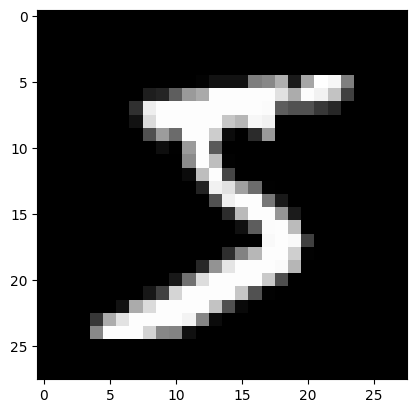

In [8]:
plt.imshow(item[0][0], cmap='gray');

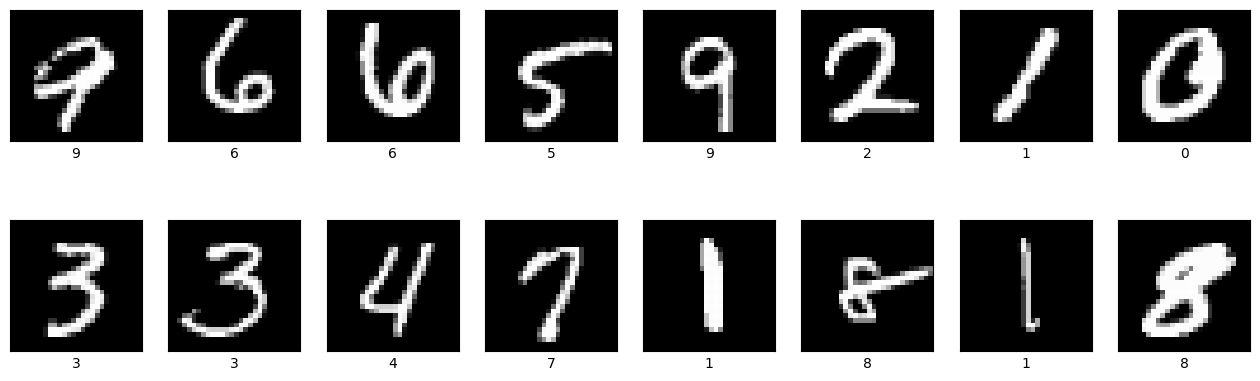

In [9]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(train_set))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(train_set[random_index][0].squeeze(0).numpy().reshape([28, 28]), cmap = 'gray')
        ax.set_xlabel(train_set[random_index][1])
plt.show()

In [10]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, shuffle=True, batch_size=64)
test_loader = DataLoader(test_set, shuffle=False, batch_size=1024)

Че такое класс: 

In [11]:
class LinearRegression(object):
    def __init__(self, param):
        self.param = param
    
    def fit(self, x):
        self.param = self.param + x
    
    def __add__(self, other):
        param = self.param + other.param
        model = LinearRegression(param)
        return model

In [12]:
model_1 = LinearRegression(42)
model_1.param

42

In [13]:
model_1.fit(42)
model_1.param

84

In [14]:
model_2 = LinearRegression(52)
model_2.param

52

In [15]:
model_3 = model_1 + model_2
model_3.param

136

In [16]:
a = 'сссс'
a.count('с')

4

Нейронка!

In [17]:
from torch import nn
import torch.nn.functional as F

In [18]:
class MyNN(nn.Module):
    def __init__(
        self, in_features, num_classes, hide_neurons):
        super(MyNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, hide_neurons),
            nn.ReLU(),
            nn.Linear(hide_neurons, hide_neurons // 2),
            nn.ReLU(),
            nn.Linear(hide_neurons//2, hide_neurons//4),
            nn.ReLU(),
            nn.Linear(hide_neurons//4, num_classes),
            # nn.Softmax()
        )
        
    def forward(self, X):
        return self.model(X)

In [19]:
model = MyNN(28**2, 10, 64)

In [20]:
# [item for item in model.named_parameters()]

In [21]:
for item in train_loader:
    break

In [22]:
torch.flatten(item[0], start_dim=1).shape

torch.Size([64, 784])

In [23]:
pred = model(torch.flatten(item[0], start_dim=1))
pred[0]

tensor([ 0.2064,  0.2033,  0.1495,  0.0548,  0.2194,  0.0273,  0.0167, -0.0564,
         0.1428,  0.0073], grad_fn=<SelectBackward0>)

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [25]:
IMG_SIZE = 28
NUM_CLASSES = 10
HIDDEN_SIZE = 64
NUM_EPOCHS = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MyNN(in_features=IMG_SIZE ** 2, num_classes=NUM_CLASSES, 
            hide_neurons=HIDDEN_SIZE).to(device)

# оптимайзер
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# функция потерь 
criterion = nn.CrossEntropyLoss()  # nn.NLLLoss()

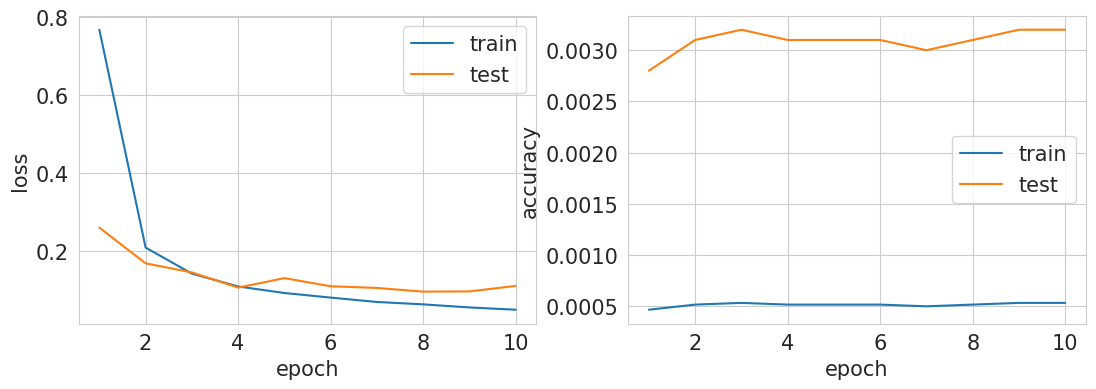

In [26]:
from tqdm.notebook import tqdm

train_losses, train_acc = [],[]
test_losses, test_acc = [],[]

for epoch in range(NUM_EPOCHS):
    train_loss, train_accuracy = 0, 0
    
    for X_batch, y_batch in train_loader:
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # 5 волшебных строчек
        optimizer.zero_grad()
        logits = model(torch.flatten(X_batch, start_dim=1))
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.shape[0]
        train_accuracy = (torch.argmax(logits, dim=-1) == y_batch).sum().item()
        
    n_train = len(train_loader.dataset)
    train_loss = train_loss/n_train
    train_losses.append(train_loss)
    train_acc.append(train_accuracy/n_train)
    
    
    test_loss, test_accuracy = 0,0
    for X_batch, y_batch in test_loader:

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        with torch.no_grad():
            logits = model(torch.flatten(X_batch, start_dim=1))
            loss = criterion(logits, y_batch)

        test_loss += loss.item() * X_batch.shape[0]
        test_accuracy = (torch.argmax(logits, dim=-1) == y_batch).sum().item()

    n_test = len(test_loader.dataset)
    test_loss = test_loss/n_test
    test_losses.append(test_loss)
    test_acc.append(train_accuracy/n_test)
        
    plot_losses(train_losses, test_losses, train_acc, test_acc)

Обернём в функцию!

In [27]:
def train():
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_accuracy = 0.0, 0.0
        
        model.train()
        for images, labels in tqdm(train_loader, desc='Training'):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(torch.flatten(images, start_dim=1))
            # logits: batch_size x num_classes
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.shape[0]
            train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        if scheduler is not None:
            scheduler.step()

        train_loss /= len(train_loader.dataset)
        train_accuracy /= len(train_loader.dataset)
        train_losses += [train_loss]
        train_accuracies += [train_accuracy]

        test_loss, test_accuracy = 0.0, 0.0
        
        model.eval()
        for images, labels in tqdm(test_loader, desc='Validating'):
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                logits = model(torch.flatten(images, start_dim=1))
                # logits: batch_size x num_classes
                loss = criterion(logits, labels)

            test_loss += loss.item() * images.shape[0]
            test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        test_loss /= len(test_loader.dataset)
        test_accuracy /= len(test_loader.dataset)
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

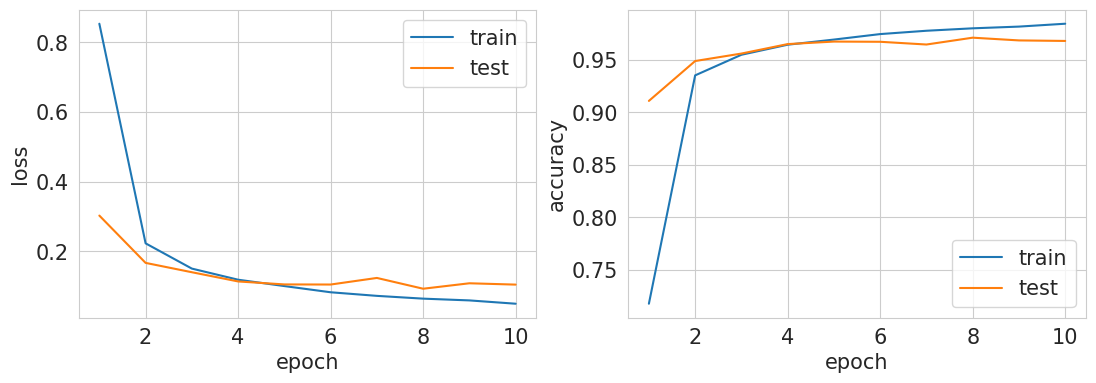

In [28]:
IMG_SIZE = 28
NUM_CLASSES = 10
HIDDEN_SIZE = 64
NUM_EPOCHS = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MyNN(IMG_SIZE ** 2, NUM_CLASSES, HIDDEN_SIZE).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = None
criterion = nn.CrossEntropyLoss()  # nn.NLLLoss()
train()

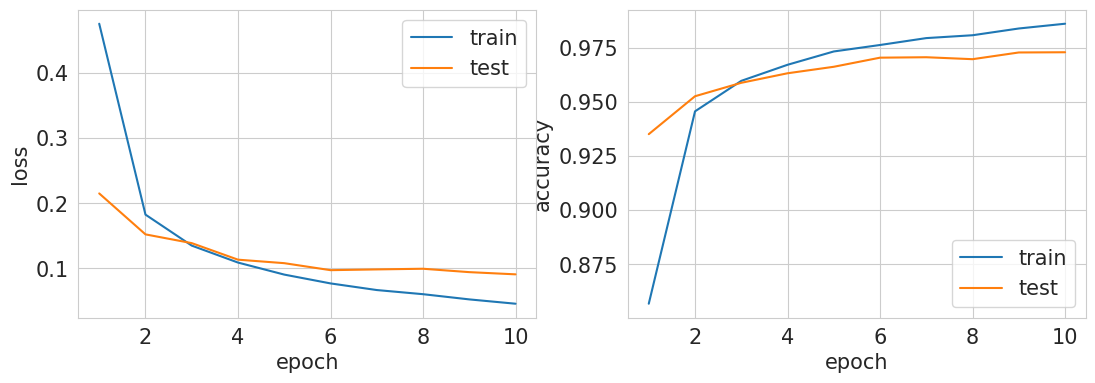

In [29]:
IMG_SIZE = 28
NUM_CLASSES = 10
HIDDEN_SIZE = 64
NUM_EPOCHS = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MyNN(IMG_SIZE ** 2, NUM_CLASSES, HIDDEN_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = None
criterion = nn.CrossEntropyLoss()
train()

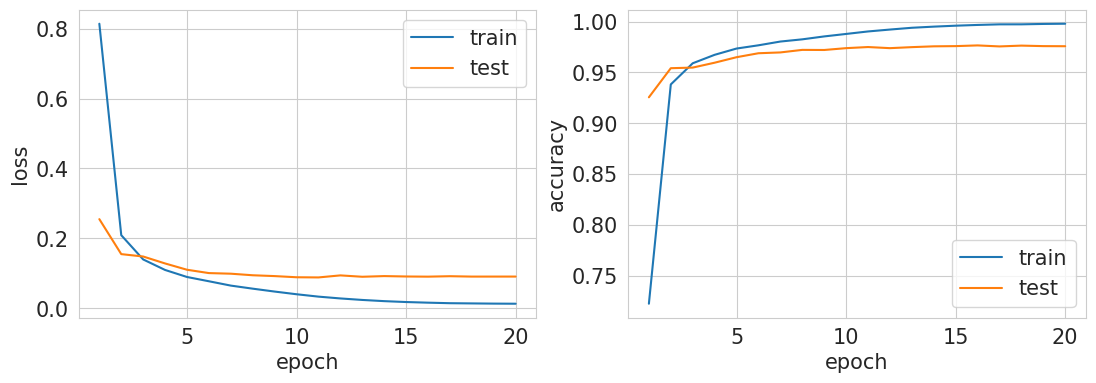

In [30]:
IMG_SIZE = 28
NUM_CLASSES = 10
HIDDEN_SIZE = 64
NUM_EPOCHS = 20

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MyNN(IMG_SIZE ** 2, NUM_CLASSES, HIDDEN_SIZE).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
criterion = nn.CrossEntropyLoss()
train()